In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

# Setup

In [2]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [3]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [4]:
model.find_ss(do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 10.00,  ss.G = 10.00,  ss.tau = 0.07
Households:
solving for household behavior: result.converged = True
ss.C = 153.06,  ss.B = 225.61,  ss.N = 74.84,  ss.B_target = 0.64
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 107.14,  ss.G_Y = 7.00,  ss.I_Y = 36.23,  ss.X_Y = 79.19
[ ss.C_M = 45.92,  ss.G_M = 3.00,  ss.I_M = 19.51,  ss.X_M = 52.79 ] = ss.M = 121.22
ss.X = 131.98
Bargaining:
par.phi = 0.988


**Household behavior:**

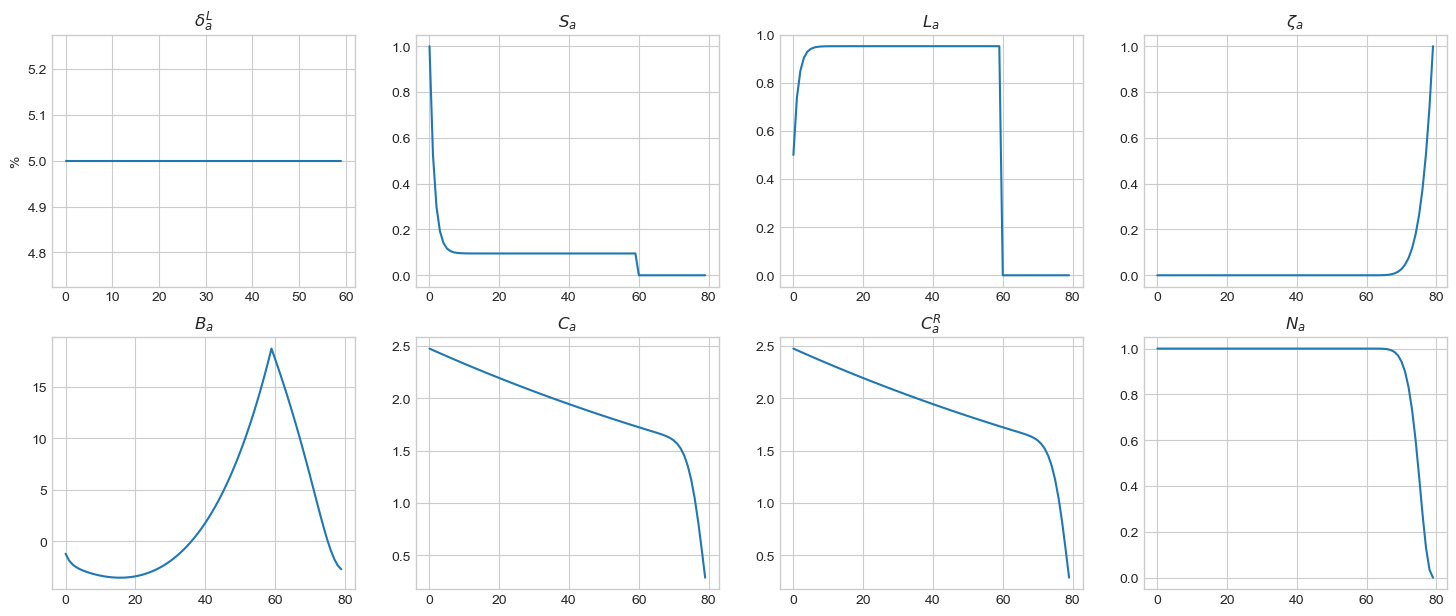

In [5]:
fig = plt.figure(figsize=(3*6,3*6/2.5))

ax = fig.add_subplot(2,4,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(2,4,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(2,4,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(2,4,4)
ax.plot(model.ss.zeta_a)
ax.set_title('$\zeta_a$')

ax = fig.add_subplot(2,4,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(2,4,6)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(2,4,7)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(2,4,8)
ax.plot(model.ss.N_a)
ax.set_ylabel('')
ax.set_title('$N_a$');

# Speed and error tests

In [6]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [7]:
%time model.evaluate_blocks(py=True)

CPU times: total: 1.86 s
Wall time: 1.88 s


**Check errors:**

In [9]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 9.07e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 5.68e-14


**First numba evaluation:**

In [10]:
%time model.evaluate_blocks()

**Time:**

In [ ]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

In [ ]:
%timeit model.evaluate_blocks(py=True)

# Find an impulse-response

**Calculate Jacobian:**

In [ ]:
model.calc_jac(do_print=True)

Only needs to be calculated once.

**Set exogenous variables:**

In [ ]:
model.set_exo_ss()

Here we shock export demand:

In [ ]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [ ]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

**Find IRF:**

In [ ]:
model.find_IRF()

**Plot:**

In [ ]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(4,4,6)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$\ell_t$')

ax = fig.add_subplot(4,4,7)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(4,4,8)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^{\ell}_t$')

ax = fig.add_subplot(4,4,9)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_s$')

ax = fig.add_subplot(4,4,10)
ax.plot((sol.S[:T_IRF]/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$S_t$')

ax = fig.add_subplot(4,4,11)
ax.plot((sol.v[:T_IRF]/(ss.v)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$v_t$')

ax = fig.add_subplot(4,4,12)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(4,4,13)
ax.plot((sol.I[:T_IRF]/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^R_t$')

ax = fig.add_subplot(4,4,14)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,4,15)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(4,4,16)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('End-of-period savings, $B^R_t$');

print('Note: resultater')

In [ ]:
Periods = [0,1,20,40,80,100]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
for t in Periods:
    L_a = np.zeros(par.A)
    for a in range(par.A):
        L_a[a] = sol.L_a[a,t+a]
    ax.plot(L_a-ss.L_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$L_{a,t}$')

ax = fig.add_subplot(2,2,2)
for t in Periods:
    S_a = np.zeros(par.A)
    for a in range(par.A):
        S_a[a] = sol.S_a[a,t+a]
    ax.plot(S_a-ss.S_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$S_{a,t}$')

ax = fig.add_subplot(2,2,3)
for t in Periods:
    C_a = np.zeros(par.A)
    for a in range(par.A):
        C_a[a] = sol.C_a[a,t+a]
    ax.plot(C_a-ss.C_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$C_{a,t}$')

ax = fig.add_subplot(2,2,4)
for t in Periods:
    B_a = np.zeros(par.A)
    for a in range(par.A):
        B_a[a] = sol.B_a[a,t+a]
    ax.plot(B_a-ss.B_a,label=f'{t = }')
ax.legend(frameon=True)
ax.set_ylabel('% of s.s.')
ax.set_title('$B_{a,t}$');



In [ ]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2,2,1)
ax.plot((sol.P_Y[:T_IRF]/ss.P_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^Y_t$')

ax = fig.add_subplot(2,2,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^C_t$')

ax = fig.add_subplot(2,2,3)
ax.plot((sol.P_I[:T_IRF]/(ss.P_I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^I_t$')

ax = fig.add_subplot(2,2,4)
ax.plot((sol.P_X[:T_IRF]/(ss.P_X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^X_t$');

# Comparison

In [ ]:
model_copy = model.copy()
model_copy.par.Lambda = 0.01
model_copy.find_ss(0.50)
model_copy.calc_jac(do_print=True)

In [ ]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
model_copy.sol.chi[:Tshock] = model_copy.ss.chi + shock*persistence

In [ ]:
model_copy.find_IRF()

In [ ]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')